### try: (use all training data) 5hr (PM2.5 + rain_sum)  |  then try removing large values (>60?) during training

In [1]:
# linear regression，方法限定使用Gradient Descent, 只能使用numpy、scipy以及pandas, numpy.linalg.lstsq是不可以用
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# numpy.version.version: 1.13.1

In [2]:
# import sys
import csv

# 18 categories in total
AMB_TEMP = []
CH4 = []
CO = []
NMHC = []
NO = []
NO2 = []
NOx = []
O3 = []
PM10 = []
PM2_5 = []
RAINFALL = []
RH = []
SO2 = []
THC = []
WD_HR = []
WIND_DIREC = []
WIND_SPEED = []
WS_HR = []

# with open(sys.argv[1]) as f:
with open('train.csv', 'rt', encoding='big5') as csvfile:
    spamreader = csv.reader(csvfile, delimiter='\n')
    row1 = next(spamreader) # skip headings
    counter = 0
    for idx, row in enumerate(spamreader): # idx starts with 0
        row = row[0].split(',')
        values = row[3:] # remove 日期、測站、測項
        values = [float(i) if i != 'NR' else 0.0 for i in values]
        # values is now sth like
        # [14.0, 14.0, 14.0, 13.0, 12.0, 12.0, 12.0, 12.0, 15.0,17.0, 20.0, 22.0,
        #  22.0, 22.0, 22.0, 22.0, 21.0, 19.0, 17.0, 16.0, 15.0, 15.0, 15.0, 15.0]
        category_num = counter % 18
        if category_num == 0:
            AMB_TEMP += values
        elif category_num == 1:
            CH4 += values
        elif category_num == 2:
            CO += values
        elif category_num == 3:
            NMHC += values
        elif category_num == 4:
            NO += values
        elif category_num == 5:
            NO2 += values
        elif category_num == 6:
            NOx += values
        elif category_num == 7:
            O3 += values
        elif category_num == 8:
            PM10 += values
        elif category_num == 9:
            PM2_5 += values
        elif category_num == 10:
            RAINFALL += values
        elif category_num == 11:
            RH += values
        elif category_num == 12:
            SO2 += values
        elif category_num == 13:
            THC += values
        elif category_num == 14:
            WD_HR += values
        elif category_num == 15:
            WIND_DIREC += values
        elif category_num == 16:
            WIND_SPEED += values
        elif category_num == 17:
            WS_HR += values
        # print(category_num, idx, values)
        counter += 1

## All features

### 9hr

In [3]:
window = 9
lr = 0.00001
batch = 20
weights = np.zeros(window * 18 + 1) # better way to initialize (maybe random)?
errors = []
# print(len(PM2_5)) # 5760 pieces of data, ~200 updates for each epoch with batch = 30
train_input = []
train_output = []
for epoch in range(0,300):
    # min=41
    # lr = 10^-5
    # 300 epochs: 67       (batch20)63
    # 150 epochs: 80
    # 100 epochs: (batch30)90    (batch20)80     (batch40)100
    # 70 epochs: 100
    # 50 epochs: 110
    # 40 epochs: 120
    # 30 epochs: (batch50)150   (batch40)120     (batch30)120    (batch20)100    (batch10)260
    # lr = 10^-6
    # 30 epochs: 150
    # lr = 10^-7
    # 30 epochs: 210
    # lr = 10^-8
    # 30 epochs: 260
    # 20 epochs: 300
    # 15 epochs: 340
    # 10 epochs: 400
    for month in range(0,12):
        for hour in range(97, 24 * 20): # skipping the first 96 (dev) hours of each month
            idx = month * 24 * 20 + hour
            if idx + window > len(PM2_5) - 1:
                break
            error = 0
            gradients = 0
            features = np.array(AMB_TEMP[idx: idx+window] + CH4[idx: idx+window] + CO[idx: idx+window] +
                        NMHC[idx: idx+window] + NO[idx: idx+window] + NO2[idx: idx+window] +
                        NOx[idx: idx+window] + O3[idx: idx+window] + PM10[idx: idx+window] +
                        PM2_5[idx: idx+window] + RAINFALL[idx: idx+window] + RH[idx: idx+window] +
                        SO2[idx: idx+window] + THC[idx: idx+window] + WD_HR[idx: idx+window] +
                        WIND_DIREC[idx: idx+window] + WIND_SPEED[idx: idx+window] + WS_HR[idx: idx+window] + [1] )
            
            # better way to write this?
            prediction = sum(np.multiply(weights, features))
            # print('prediction', prediction)
            answer = PM2_5[idx+window]
            # print('answer', answer)
            
            if epoch == 0:
                train_input.append(features)
                train_output.append(answer)
            
            error += (answer - prediction)**2
            gradients += -2 * (answer - prediction) * features # this works because for b, there is -1
            # print(gradients)
            if idx % batch == 6: # first batch will have extra 1 data
                weights = weights - lr * gradients / batch
                errors.append(error / batch)
                # print('error', error / batch)
                error = 0
                gradients = 0
                
test_errors = []
test_input = []
test_output = []
for month in range(0,12):
    for hour in range(0,96):
        idx = month * 24 * 20 + hour
        features = np.array(AMB_TEMP[idx: idx+window] + CH4[idx: idx+window] + CO[idx: idx+window] +
                    NMHC[idx: idx+window] + NO[idx: idx+window] + NO2[idx: idx+window] +
                    NOx[idx: idx+window] + O3[idx: idx+window] + PM10[idx: idx+window] +
                    PM2_5[idx: idx+window] + RAINFALL[idx: idx+window] + RH[idx: idx+window] +
                    SO2[idx: idx+window] + THC[idx: idx+window] + WD_HR[idx: idx+window] +
                    WIND_DIREC[idx: idx+window] + WIND_SPEED[idx: idx+window] + WS_HR[idx: idx+window] + [1] )
        test_input.append(features)
        
        prediction = sum(np.multiply(weights, features))
        
        answer = PM2_5[idx+window]
        test_output.append(answer)
        
        error = (answer - prediction)**2
        test_errors.append(error)
        
best_train_weights = np.linalg.lstsq(train_input, train_output)[0]
best_train_predictions = np.dot(train_input, best_train_weights)
best_train_errors = (train_output - best_train_predictions) ** 2

train_predictions = np.dot(train_input, weights)
train_errors = (train_output - train_predictions) ** 2

# best_weights = np.linalg.lstsq(test_input, test_output)[0]
best_predictions = np.dot(test_input, best_train_weights)
best_errors = (test_output - best_predictions) ** 2

print('average test error', np.average(test_errors))
print('best average test error', np.average(best_errors))
print('average train error', np.average(train_errors))
print('best average train error', np.average(best_train_errors))

average test error 62.7319910117
best average test error 41.8418657759
average train error 57.2568151555
best average train error 31.9914021499


### 5hr

In [8]:
window = 5
lr = 0.00001
batch = 30
weights = np.zeros(window * 18 + 1) # better way to initialize (maybe random)?
errors = []
# print(len(PM2_5)) # 5760 pieces of data, ~200 updates for each epoch with batch = 30
train_input = []
train_output = []
for epoch in range(0,300):
    # min=41, (default = batch30)
    # lr = 10^-5
    # 300 epochs: 67->56.1       (batch20)63->62
    # 150 epochs: 80
    # 100 epochs: (batch30)90->63.1    (batch20)80->70.5     (batch40)100
    # 70 epochs: 100
    # 50 epochs: 110
    # 40 epochs: 120
    # 30 epochs: (batch50)150   (batch40)120->108     (batch30)120->81    (batch20)100->98    (batch10)260
    # lr = 10^-6
    # 30 epochs: 150
    # lr = 10^-7
    # 30 epochs: 210
    # lr = 10^-8
    # 30 epochs: 260
    # 20 epochs: 300
    # 15 epochs: 340
    # 10 epochs: 400
    for month in range(0,12):
        for hour in range(97, 24 * 20): # skipping the first 96 (dev) hours of each month
            idx = month * 24 * 20 + hour
            if idx + window > len(PM2_5) - 1:
                break
            error = 0
            gradients = 0
            features = np.array(AMB_TEMP[idx: idx+window] + CH4[idx: idx+window] + CO[idx: idx+window] +
                        NMHC[idx: idx+window] + NO[idx: idx+window] + NO2[idx: idx+window] +
                        NOx[idx: idx+window] + O3[idx: idx+window] + PM10[idx: idx+window] +
                        PM2_5[idx: idx+window] + RAINFALL[idx: idx+window] + RH[idx: idx+window] +
                        SO2[idx: idx+window] + THC[idx: idx+window] + WD_HR[idx: idx+window] +
                        WIND_DIREC[idx: idx+window] + WIND_SPEED[idx: idx+window] + WS_HR[idx: idx+window] + [1] )
            
            # better way to write this?
            prediction = sum(np.multiply(weights, features))
            # print('prediction', prediction)
            answer = PM2_5[idx+window]
            # print('answer', answer)
            
            if epoch == 0:
                train_input.append(features)
                train_output.append(answer)
            
            error += (answer - prediction)**2
            gradients += -2 * (answer - prediction) * features # this works because for b, there is -1
            # print(gradients)
            if idx % batch == 6: # first batch will have extra 1 data
                weights = weights - lr * gradients / batch
                errors.append(error / batch)
                # print('error', error / batch)
                error = 0
                gradients = 0
                
test_errors = []
test_input = []
test_output = []
for month in range(0,12):
    for hour in range(0,96):
        idx = month * 24 * 20 + hour
        features = np.array(AMB_TEMP[idx: idx+window] + CH4[idx: idx+window] + CO[idx: idx+window] +
                    NMHC[idx: idx+window] + NO[idx: idx+window] + NO2[idx: idx+window] +
                    NOx[idx: idx+window] + O3[idx: idx+window] + PM10[idx: idx+window] +
                    PM2_5[idx: idx+window] + RAINFALL[idx: idx+window] + RH[idx: idx+window] +
                    SO2[idx: idx+window] + THC[idx: idx+window] + WD_HR[idx: idx+window] +
                    WIND_DIREC[idx: idx+window] + WIND_SPEED[idx: idx+window] + WS_HR[idx: idx+window] + [1] )
        test_input.append(features)
        
        prediction = sum(np.multiply(weights, features))
        
        answer = PM2_5[idx+window]
        test_output.append(answer)
        
        error = (answer - prediction)**2
        test_errors.append(error)
        
best_train_weights = np.linalg.lstsq(train_input, train_output)[0]
best_train_predictions = np.dot(train_input, best_train_weights)
best_train_errors = (train_output - best_train_predictions) ** 2

train_predictions = np.dot(train_input, weights)
train_errors = (train_output - train_predictions) ** 2

# best_weights = np.linalg.lstsq(test_input, test_output)[0]
best_predictions = np.dot(test_input, best_train_weights)
best_errors = (test_output - best_predictions) ** 2

print('average test error', np.average(test_errors))
print('best average test error', np.average(best_errors))
print('average train error', np.average(train_errors))
print('best average train error', np.average(best_train_errors))

average test error 56.1190085347
best average test error 41.617105073
average train error 50.6093814074
best average train error 33.4592214599


## Only PM2_5 feature

### 9hr

In [16]:
window = 9
lr = 0.0001
batch = 10
weights = np.zeros(window + 1) # better way to initialize (maybe random)?
errors = []
# print(len(PM2_5)) # 5760 pieces of data, ~200 updates for each epoch with batch = 30
train_input = []
train_output = []
for epoch in range(0,50): # seems to have already converged by 3rd epoch
    # min=44
    # lr = 10^-4，再調低，還是很難低於 48
    # epoch50: (batch10)47.6    epoch30: (batch10)48   (batch20)52  (batch30)56   (batch40)62
    # lr = 10^-5
    # epoch30: 73
    for month in range(0,12):
        for hour in range(97, 24 * 20): # skipping the first 96 (dev) hours of each month
            idx = month * 24 * 20 + hour
            if idx + window > len(PM2_5) - 1:
                break
            error = 0
            gradients = 0
            features = np.array(PM2_5[idx: idx+window] + [1] )
            
            # better way to write this?
            prediction = sum(np.multiply(weights, features))
            # print('prediction', prediction)
            answer = PM2_5[idx+window]
            # print('answer', answer)
            
            if epoch == 0:
                train_input.append(features)
                train_output.append(answer)
            
            error += (answer - prediction)**2
            gradients += -2 * (answer - prediction) * features # this works because for b, there is -1
            # print(gradients)
            if idx % batch == 6: # first batch will have extra 1 data
                weights = weights - lr * gradients / batch
                errors.append(error / batch)
                # print('error', error / batch)
                error = 0
                gradients = 0
                
test_errors = []
test_input = []
test_output = []
for month in range(0,12):
    for hour in range(0,96):
        idx = month * 24 * 20 + hour
        features = np.array(PM2_5[idx: idx+window] + [1] )
        test_input.append(features)
        
        prediction = sum(np.multiply(weights, features))
        
        answer = PM2_5[idx+window]
        test_output.append(answer)
        
        error = (answer - prediction)**2
        test_errors.append(error)
        
best_train_weights = np.linalg.lstsq(train_input, train_output)[0]
best_train_predictions = np.dot(train_input, best_train_weights)
best_train_errors = (train_output - best_train_predictions) ** 2

train_predictions = np.dot(train_input, weights)
train_errors = (train_output - train_predictions) ** 2

# best_weights = np.linalg.lstsq(test_input, test_output)[0]
best_predictions = np.dot(test_input, best_train_weights)
best_errors = (test_output - best_predictions) ** 2

print('average test error', np.average(test_errors))
print('best average test error', np.average(best_errors))
print('average train error', np.average(train_errors))
print('best average train error', np.average(best_train_errors))

average test error 47.6686057357
best average test error 43.6627082838
average train error 39.0976201455
best average train error 37.4491128514


### 5hr

In [198]:
window = 5 # (6)46.89, min=44.86 (5)46.12, min=44.57 (4)46.15, min=45.7 (3)55.48, min=52.47
lr = 0.0001
batch = 10
weights = np.zeros(window + 1) # better way to initialize (maybe random)?
errors = []
# print(len(PM2_5)) # 5760 pieces of data, ~200 updates for each epoch with batch = 30
train_input = []
train_output = []
for epoch in range(0,200):
    # min=44.5
    # lr = 10^-4
    # epoch200: (batch10)???->46.1
    # epoch100: (batch10)???->46.5    (batch20)???->47.5
    # epoch50: (batch10)47.6->46.8    (batch20)???->49.56
    # epoch30: (batch10)48   (batch20)52  (batch30)56   (batch40)62
    # lr = 10^-5
    # epoch30: 73
    for month in range(0,12):
        for hour in range(97, 24 * 20): # skipping the first 96 (dev) hours of each month
            idx = month * 24 * 20 + hour
            if idx + window > len(PM2_5) - 1:
                break
            error = 0
            gradients = 0
            features = np.array(PM2_5[idx: idx+window] + [1] )
            
            # better way to write this?
            prediction = sum(np.multiply(weights, features))
            # print('prediction', prediction)
            answer = PM2_5[idx+window]
            # print('answer', answer)
            
            if epoch == 0:
                train_input.append(features)
                train_output.append(answer)
            
            error += (answer - prediction)**2
            
            gradients += -2 * (answer - prediction) * features # this works because for b, there is -1
            # print(gradients)
            if idx % batch == 6: # first batch will have extra 1 data
                weights = weights - lr * gradients / batch
                errors.append(error / batch)
                # print('error', error / batch)
                error = 0
                gradients = 0
                
test_errors = []
test_input = []
test_output = []
for month in range(0,12):
    for hour in range(0,96):
        idx = month * 24 * 20 + hour
        features = np.array(PM2_5[idx: idx+window] + [1] )
        test_input.append(features)
        
        prediction = sum(np.multiply(weights, features))
        
        answer = PM2_5[idx+window]
        test_output.append(answer)
        
        error = (answer - prediction)**2
        test_errors.append(error)
        
best_train_weights = np.linalg.lstsq(train_input, train_output)[0]
best_train_predictions = np.dot(train_input, best_train_weights)
best_train_errors = (train_output - best_train_predictions) ** 2

train_predictions = np.dot(train_input, weights)
train_errors = (train_output - train_predictions) ** 2

# best_weights = np.linalg.lstsq(test_input, test_output)[0]
best_predictions = np.dot(test_input, best_train_weights)
best_errors = (test_output - best_predictions) ** 2

print('average test error', np.average(test_errors))
print('best average test error', np.average(best_errors))
print('average train error', np.average(train_errors))
print('best average train error', np.average(best_train_errors))

average test error 46.1298720346
best average test error 44.5785360514
average train error 39.3951670465
best average train error 38.3654288875


### 5hr + other features

In [42]:
# scores to beat:
# 46.12 (window=5, PM2.5)
# epoch200: (batch10)46.1->45.7
# epoch100: (batch10)46.5->45.4    (batch20)47.5
# epoch50: (batch10)46.8->45   (batch20)49.56
my_lambda = 1

window = 5 # (6)46.89, min=44.86 (5)46.12, min=44.57 (4)46.15, min=45.7 (3)55.48, min=52.47
lr = 0.0001
batch = 10
weights = np.zeros(window + 1 + 1) # better way to initialize (maybe random)?

errors = []
train_input = []
train_output = []

counter = 0
error = 0
gradients = 0

for epoch in range(0,50):
    # min=44.5-->44.5
    # lr = 10^-4
    # epoch200: (batch10)???->46.1-->46.09
    # epoch100: (batch10)???->46.5-->46.45    (batch20)???->47.5
    # epoch50: (batch10)47.6->46.8    (batch20)???->49.56
    # epoch30: (batch10)48-->46.8   (batch20)52-->47.4  (batch30)56-->51.7   (batch40)62
    # lr = 10^-5
    # epoch30: 73
    for month in range(0,12):
        for hour in range(97, 24 * 20): # skipping the first 96 (dev) hours of each month
            idx = month * 24 * 20 + hour
            if idx + window > len(PM2_5) - 1:
                break
            
            features = np.array(PM2_5[idx: idx+window]) #
            
            PM25_squared = 0.01* (features ** 2)
            # PM25_squared_last = PM25_squared[-1]
            PM25_deltas = np.array([(PM2_5[i+1] - PM2_5[i]) for i in range(idx, idx+window-1)])
            PM25_deltas_squared = 0.01 * (PM25_deltas ** 2)
            # PM25_delta_last = PM2_5[idx+window-1] - PM2_5[idx+window-2]
            # rain_deltas = np.array([(RAINFALL[i+1] - RAINFALL[i]) for i in range(idx, idx+window-1)])
            # rain_delta_middle = rain_deltas[1]
            # PM25_PM10 = np.sqrt(abs(features * np.array(PM10[idx: idx+window])))
            rain = np.array(RAINFALL[idx: idx+window])
            rain_sum = sum(rain)
            
            # features = np.append(features, PM25_deltas)
            features = np.append(features, rain_sum)
            # features = np.append(features, PM25_deltas_squared)
            # features = np.append(features, PM25_squared)
            features = np.append(features, 1.0)
            
            # better way to write this?
            prediction = sum(np.multiply(weights, features))
            # print('prediction', prediction)
            answer = PM2_5[idx+window]
            # print('answer', answer)
            
            if(answer < 70):
                if epoch == 0:
                    train_input.append(features)
                    train_output.append(answer)

                error += (answer - prediction)**2

                l1 = np.array([1 if num > 0 else -1 for num in weights[:-1]] + [0])
                l2 = 2 * my_lambda * np.append(weights[:-1],0)
                gradients += -2 * (answer - prediction) * features + l2 # this works because for b, there is -1
                
                counter += 1
                if counter % batch == 0:
                    weights = weights - lr * gradients / batch
                    errors.append(error / batch)
                    # print('error', error / batch)
                    error = 0
                    gradients = 0
                


print('finished training!')

finished training!


In [44]:
test_errors = []
test_input = [] # features
test_output = [] # correct answers
test_predictions = []
for month in range(0,12):
    for hour in range(0,96):
        idx = month * 24 * 20 + hour
        
        features = np.array(PM2_5[idx: idx+window]) # previous 5hr
        
        PM25_squared = 0.01* (features ** 2)
        # PM25_squared_last = PM25_squared[-1]
        PM25_deltas = np.array([(PM2_5[i+1] - PM2_5[i]) for i in range(idx, idx+window-1)])
        PM25_deltas_squared = 0.01 * (PM25_deltas ** 2)
        # PM25_delta_last = PM2_5[idx+window-1] - PM2_5[idx+window-2]
        # rain_deltas = np.array([(RAINFALL[i+1] - RAINFALL[i]) for i in range(idx, idx+window-1)])
        # rain_delta_middle = rain_deltas[1]
        # PM25_PM10 = np.sqrt(abs(features * np.array(PM10[idx: idx+window])))
        rain = np.array(RAINFALL[idx: idx+window])
        rain_sum = sum(rain)
        
        features = np.append(features, rain_sum)
        # features = np.append(features, PM25_deltas)
        # features = np.append(features, PM25_deltas_squared)
        # features = np.append(features, rain_delta_middle)
        # features = np.append(features, PM25_squared)
        features = np.append(features, 1.0)
        test_input.append(features)
        
        prediction = sum(np.multiply(weights, features))
        test_predictions.append(prediction)
        
        answer = PM2_5[idx+window]
        test_output.append(answer)
        
        error = (answer - prediction)**2
        test_errors.append(error)

best_train_weights = np.linalg.lstsq(train_input, train_output)[0]
best_train_predictions = np.dot(train_input, best_train_weights)
best_train_errors = (train_output - best_train_predictions) ** 2

train_predictions = np.dot(train_input, weights)
train_errors = (train_output - train_predictions) ** 2

# best_weights = np.linalg.lstsq(test_input, test_output)[0]
best_predictions = np.dot(test_input, best_train_weights)
best_errors = (test_output - best_predictions) ** 2

print('average test error', np.average(test_errors))
print('best average test error', np.average(best_errors))
print('average train error', np.average(train_errors))
print('best average train error', np.average(best_train_errors))

average test error 45.0385905351
best average test error 44.3032632912
average train error 35.0613209802
best average train error 34.8204939268


#### training weights after I get "good" closed form (can't replicate closed form weights, damn...)

In [190]:
scaled_train_x = train_x
# scaled_train_x = (scaled_train_x - np.mean(scaled_train_x, axis=0)) / np.std(scaled_train_x, axis=0)
# the above method will encounter dividing by 0
scaled_train_x = scaled_train_x / np.max(scaled_train_x, axis=0)
# print(scaled_train_x[0:10])

[[ 0.23214286  0.34821429  0.32142857 ...,  0.00464876  0.00528926  1.        ]
 [ 0.34821429  0.32142857  0.3125     ...,  0.00528926  0.05373967  1.        ]
 [ 0.32142857  0.3125      0.27678571 ...,  0.05373967  0.46487603  1.        ]
 ..., 
 [ 0.17857143  0.16964286  0.26785714 ...,  0.02677686  0.03142562  1.        ]
 [ 0.16964286  0.26785714  0.36607143 ...,  0.03142562  0.04        1.        ]
 [ 0.26785714  0.36607143  0.39285714 ...,  0.04        0.2025      1.        ]]


In [203]:
num_epochs = 500
lr = 0.000000000000001
# epoch 80: 6.6

learning_rates = [1.0] # for adagrad         
weights = np.zeros(len(train_x[0]))
for epoch in range(1, num_epochs+1):
    error = 0 # to initialize
    for count, x in enumerate(train_x):
        prediction = sum(np.multiply(weights, x))
        answer = train_y[count]
        error = (answer - prediction)**2 # for seeing if training error is lowering
        gradients = -2 * (answer - prediction) * x
        
        adagrad_denom = np.sqrt(sum(np.array(learning_rates) ** 2))
        new_lr = lr / adagrad_denom
        learning_rates += new_lr
        weights = weights - new_lr * gradients
    if(epoch % 10 == 0):
        print('error after epoch', epoch, ':', error)

scaled_test_x = test_x
scaled_test_x = scaled_test_x / np.max(scaled_test_x, axis=0)

trained_test_predictions = np.dot(scaled_test_x, weights)
trained_test_errors = (test_y - trained_test_predictions) ** 2
print('trained test error', np.average(trained_test_errors))

error after epoch 10 : 142.939565994


KeyboardInterrupt: 

## Closed form goodness

In [3]:
window = 8

train_x = []
train_y = []
for month in range(0,12):
    for hour in range(97-97, 24 * 20-97): # skipping the first 96 (dev) hours of each month
        idx = month * 24 * 20 + hour
        if idx + window > len(PM2_5) - 1:
            break
        
        features = np.array(PM2_5[idx: idx+window])
        features = np.append(features, RAINFALL[idx:idx+window])
        # features = np.append(features, NMHC[idx:idx+window])
        features = np.append(features, PM10[idx:idx+window])
        features = np.append(features, O3[idx:idx+window])
        # features = np.append(features, np.array(PM10[idx:idx+window])**2)
        features = np.append(features, np.array(RAINFALL[idx:idx+window])**3)
        features = np.append(features, NOx[idx:idx+window])
        # features = np.append(features, np.array(PM2_5[idx+window-1])**2)
        features = np.append(features, np.array(PM2_5[idx: idx+window]) * np.array(PM10[idx: idx+window]))
        features = np.append(features, WIND_DIREC[idx+5:idx+window])
        features = np.append(features, np.array(WIND_DIREC[idx+5:idx+window]) ** 2)
        features = np.append(features, CH4[idx:idx+window])
        features = np.append(features, np.array(CH4[idx:idx+window])**2)
        features = np.append(features, np.array(WIND_DIREC[idx:idx+window])* np.array(PM2_5[idx: idx+window]))
        features = np.append(features, WIND_SPEED[idx+5:idx+window])
        features = np.append(features, RH[idx:idx+window])
        features = np.append(features, np.array(RH[idx:idx+window])**2)
        features = np.append(features, SO2[idx:idx+window])
        features = np.append(features, np.array(SO2[idx:idx+window])**2)
        features = np.append(features, [1.0])
        
        answer = PM2_5[idx+window]
        # print('answer', answer)

        train_x.append(features)
        train_y.append(answer)
        

test_x = []
test_y = []
for month in range(0,12):
    for hour in range(24 * 20-97,24 * 20-97+96):
        idx = month * 24 * 20 + hour
        if idx + window > len(PM2_5) - 1:
            break
        
        features = np.array(PM2_5[idx: idx+window])
        features = np.append(features, RAINFALL[idx:idx+window])
        # features = np.append(features, NMHC[idx:idx+window])
        features = np.append(features, PM10[idx:idx+window])
        features = np.append(features, O3[idx:idx+window])
        # features = np.append(features, np.array(PM10[idx:idx+window])**2)
        features = np.append(features, np.array(RAINFALL[idx:idx+window])**3)
        features = np.append(features, NOx[idx:idx+window])
        # features = np.append(features, np.array(PM2_5[idx+window-1])**2)
        features = np.append(features, np.array(PM2_5[idx: idx+window]) * np.array(PM10[idx: idx+window]))
        features = np.append(features, WIND_DIREC[idx+5:idx+window])
        features = np.append(features, np.array(WIND_DIREC[idx+5:idx+window]) ** 2)
        features = np.append(features, CH4[idx:idx+window])
        features = np.append(features, np.array(CH4[idx:idx+window])**2)
        features = np.append(features, np.array(WIND_DIREC[idx:idx+window])* np.array(PM2_5[idx: idx+window]))
        features = np.append(features, WIND_SPEED[idx+5:idx+window])
        features = np.append(features, RH[idx:idx+window])
        features = np.append(features, np.array(RH[idx:idx+window])**2)
        features = np.append(features, SO2[idx:idx+window])
        features = np.append(features, np.array(SO2[idx:idx+window])**2)
        features = np.append(features, [1.0])
        
        answer = PM2_5[idx+window]
        
        test_x.append(features)
        test_y.append(answer)

        
best_train_weights = np.linalg.lstsq(train_x, train_y)[0]
np.savetxt('best_weights.txt', best_train_weights)
# import pickle
# with open('weights.pickle', 'wb') as f:  # Python 3: open(..., 'wb')
#    pickle.dump([best_train_weights], f)

best_test_predictions = np.dot(test_x, best_train_weights)
best_test_errors = (test_y - best_test_predictions) ** 2

print('best average test error', np.average(best_test_errors))

best average test error 42.3552273538


##### experiment

In [51]:
window = 4

# score to beat: 41.102 (window=4, add PM10, O3, NOx, 
           # PM25 * PM10, CH4, CH4^2, PM2_5*WIND_DIREC, WIND_SPEED, RH
           # RH^2, SO2, SO2^2, RAINFALL*PM25, PM25_deltas)

# score to beat: 42.355 (window=8, add RAINFALL, PM10, O3, RAINFALL^3, NOx, 
           # PM25 * PM10, WIND_DIREC_last3, WIND_DIREC_last3^2, CH4, CH4^2, PM2_5*WIND_DIREC, WIND_SPEED, RH
           # RH^2, SO2, SO2^2)
# add squared: 46.018

train_x = []
train_y = []
for month in range(0,12):
    for hour in range(97-97, 24 * 20-97): # skipping the first 96 (dev) hours of each month
        idx = month * 24 * 20 + hour
        if idx + window > len(PM2_5) - 1:
            break
        
        features = np.array(PM2_5[idx: idx+window])
        PM25_squared = features ** 2
        
        # features = np.append(features, RAINFALL[idx:idx+window])
        # features = np.append(features, NMHC[idx:idx+window])
        features = np.append(features, PM10[idx:idx+window])
        features = np.append(features, O3[idx:idx+window])
        # features = np.append(features, np.array(PM10[idx:idx+window])**2)
        # features = np.append(features, np.array(RAINFALL[idx:idx+window])**3)
        features = np.append(features, NOx[idx:idx+window])
        # features = np.append(features, np.array(PM2_5[idx+window-1])**2)
        features = np.append(features, np.array(PM2_5[idx: idx+window]) * np.array(PM10[idx: idx+window]))
        # features = np.append(features, WIND_DIREC[idx+5:idx+window])
        # features = np.append(features, np.array(WIND_DIREC[idx+5:idx+window]) ** 2)
        features = np.append(features, CH4[idx:idx+window])
        features = np.append(features, np.array(CH4[idx:idx+window])**2)
        features = np.append(features, np.array(WIND_DIREC[idx:idx+window])* np.array(PM2_5[idx: idx+window]))
        # features = np.append(features, WIND_SPEED[idx+5:idx+window])
        features = np.append(features, RH[idx:idx+window])
        features = np.append(features, np.array(RH[idx:idx+window])**2)
        features = np.append(features, SO2[idx:idx+window])
        features = np.append(features, np.array(SO2[idx:idx+window])**2)
        features = np.append(features, np.array(PM2_5[idx:idx+window]) * np.array(RAINFALL[idx:idx+window]))
        PM2_5_deltas = np.array(PM2_5[idx+1:idx+window]) - np.array(PM2_5[idx:idx+window-1])
        features = np.append(features, PM2_5_deltas)
        features = np.append(features, [1.0])
        
        answer = PM2_5[idx+window]
        # print('answer', answer)

        train_x.append(features)
        train_y.append(answer)
        

test_x = []
test_y = []
for month in range(0,12):
    for hour in range(24 * 20-97,24 * 20-97+96):
        idx = month * 24 * 20 + hour
        if idx + window > len(PM2_5) - 1:
            break
        
        features = np.array(PM2_5[idx: idx+window])
        # features = np.append(features, RAINFALL[idx:idx+window])
        # features = np.append(features, NMHC[idx:idx+window])
        features = np.append(features, PM10[idx:idx+window])
        features = np.append(features, O3[idx:idx+window])
        # features = np.append(features, np.array(PM10[idx:idx+window])**2)
        # features = np.append(features, np.array(RAINFALL[idx:idx+window])**3)
        features = np.append(features, NOx[idx:idx+window])
        # features = np.append(features, np.array(PM2_5[idx+window-1])**2)
        features = np.append(features, np.array(PM2_5[idx: idx+window]) * np.array(PM10[idx: idx+window]))
        # features = np.append(features, WIND_DIREC[idx+5:idx+window])
        # features = np.append(features, np.array(WIND_DIREC[idx+5:idx+window]) ** 2)
        features = np.append(features, CH4[idx:idx+window])
        features = np.append(features, np.array(CH4[idx:idx+window])**2)
        features = np.append(features, np.array(WIND_DIREC[idx:idx+window])* np.array(PM2_5[idx: idx+window]))
        # features = np.append(features, WIND_SPEED[idx+5:idx+window])
        features = np.append(features, RH[idx:idx+window])
        features = np.append(features, np.array(RH[idx:idx+window])**2)
        features = np.append(features, SO2[idx:idx+window])
        features = np.append(features, np.array(SO2[idx:idx+window])**2)
        features = np.append(features, np.array(PM2_5[idx:idx+window]) * np.array(RAINFALL[idx:idx+window]))
        PM2_5_deltas = np.array(PM2_5[idx+1:idx+window]) - np.array(PM2_5[idx:idx+window-1])
        features = np.append(features, PM2_5_deltas)
        features = np.append(features, [1.0])
        
        answer = PM2_5[idx+window]
        
        test_x.append(features)
        test_y.append(answer)

        
best_train_weights = np.linalg.lstsq(train_x, train_y)[0]
np.savetxt('best_weights.txt', best_train_weights)
# import pickle
# with open('weights.pickle', 'wb') as f:  # Python 3: open(..., 'wb')
#    pickle.dump([best_train_weights], f)

best_test_predictions = np.dot(test_x, best_train_weights)
best_test_errors = (test_y - best_test_predictions) ** 2

print('best average test error', np.average(best_test_errors))

best average test error 41.1019895154


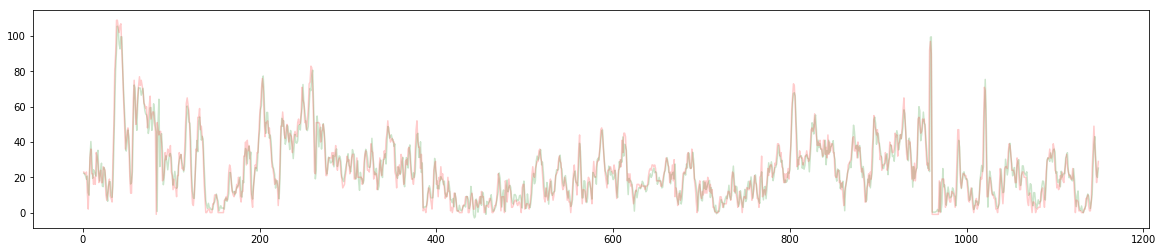

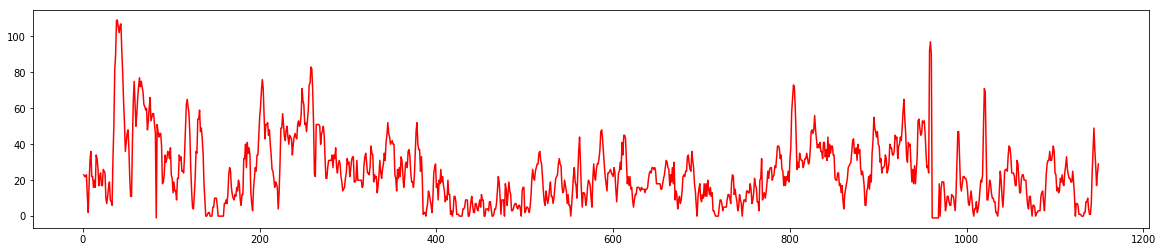

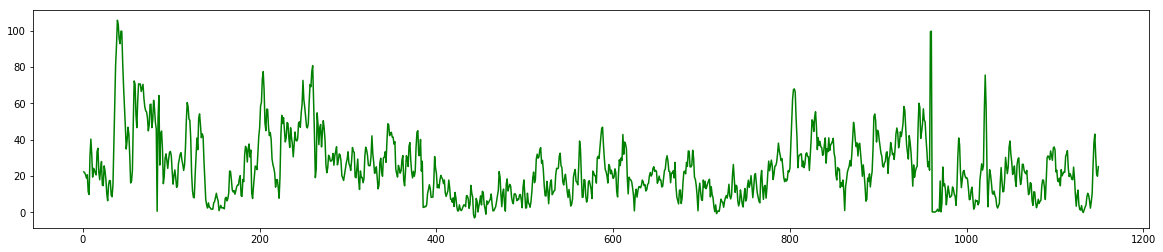

In [44]:
# plt.plot(test_errors)

x = [i for i in range(1, len(best_test_predictions) + 1)]

plt.figure(figsize=(20,4))
plt.plot(x, best_test_predictions, 'g', x, test_y, 'r', alpha=0.2)

plt.figure(figsize=(20,4))
plt.plot(x, test_y, 'r')

plt.figure(figsize=(20,4))
plt.plot(x, best_test_predictions, 'g')

In [215]:
print(len(weights))
print(weights)

122
[  5.78794914e-08   5.87957458e-08   5.97322735e-08   6.08162601e-08
   6.21808525e-08   6.34549194e-08   6.68669169e-08   6.98245129e-08
   7.45813181e-11   6.51345628e-11   5.96309068e-11   6.55239944e-11
   8.21409416e-11   9.78612204e-11   9.49449718e-11   1.15714064e-10
   1.06045246e-07   1.07299471e-07   1.08630452e-07   1.10062445e-07
   1.11923562e-07   1.14129114e-07   1.16330126e-07   1.18144515e-07
   7.01723594e-08   7.07850454e-08   7.13345088e-08   7.18473914e-08
   7.23820706e-08   7.28828921e-08   7.32377646e-08   7.32611575e-08
  -1.72681477e-08  -2.80816661e-08  -4.55173515e-08  -3.64368048e-08
  -2.41822116e-08  -2.36712575e-09  -4.90288247e-08  -5.35943188e-08
   2.91305709e-08   2.94648833e-08   2.97856370e-08   3.01532918e-08
   3.04629331e-08   3.07524271e-08   3.08938957e-08   3.07255410e-08
   3.95403032e-06   4.03009987e-06   4.10708551e-06   4.21305390e-06
   4.35487572e-06   4.50932915e-06   4.76175228e-06   4.98308697e-06
   3.25141061e-07   3.23405903

## Best model for submission

In [41]:
# Remember to run model and get weights before running this!!!

test_AMB_TEMP = []
test_CH4 = []
test_CO = []
test_NMHC = []
test_NO = []
test_NO2 = []
test_NOx = []
test_O3 = []
test_PM10 = []
test_PM2_5 = []
test_RAINFALL = []
test_RH = []
test_SO2 = []
test_THC = []
test_WD_HR = []
test_WIND_DIREC = []
test_WIND_SPEED = []
test_WS_HR = []

window = 4

with open('test.csv', 'rt', encoding='big5') as infile:
    with open('submission.csv', 'wt') as outfile:
        test_reader = csv.reader(infile, delimiter='\n')
        test_writer = csv.writer(outfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        test_writer.writerow(['id','value'])
        counter = 0
        for idx, row in enumerate(test_reader):
            
            row = row[0].split(',')
            # print('row', row)
            values = row[2:] # remove id, category
            values = [float(i) if i != 'NR' else 0.0 for i in values]
            
            category_num = idx % 18
            if category_num == 0:
                test_AMB_TEMP = values
            elif category_num == 1:
                test_CH4 = values
            elif category_num == 2:
                test_CO = values
            elif category_num == 3:
                test_NMHC = values
            elif category_num == 4:
                test_NO = values
            elif category_num == 5:
                test_NO2 = values
            elif category_num == 6:
                test_NOx = values
            elif category_num == 7:
                test_O3 = values
            elif category_num == 8:
                test_PM10 = values
            elif category_num == 9:
                test_PM2_5 = values
            elif category_num == 10:
                test_RAINFALL = values
            elif category_num == 11:
                test_RH = values
            elif category_num == 12:
                test_SO2 = values
            elif category_num == 13:
                test_THC = values
            elif category_num == 14:
                test_WD_HR = values
            elif category_num == 15:
                test_WIND_DIREC = values
            elif category_num == 16:
                test_WIND_SPEED = values
            elif category_num == 17:
                test_WS_HR = values
                
                # finished reading an id, can go to work now
                # features = np.array(test_PM2_5[-window:])
                # test_PM25_squared = 0.01* (features ** 2)
                # PM25_squared_last = PM25_squared[-1]
                # test_PM25_deltas = np.array([(test_PM2_5[-i] - test_PM2_5[-i-1]) for i in range(1, window)])
                # test_PM25_deltas_squared = 0.01 * (test_PM25_deltas ** 2)
                # PM25_delta_last = PM2_5[idx+window-1] - PM2_5[idx+window-2]
                # test_rain_deltas = np.array([(test_RAINFALL[-i] - test_RAINFALL[-i-1]) for i in range(1, window)])
                # test_rain_delta_middle = test_rain_deltas[1]
                # PM25_PM10 = np.sqrt(abs(features * np.array(PM10[idx: idx+window])))
                rain = np.array(test_RAINFALL[-window:])
                rain_sum = sum(rain)

                # features = np.append(features, test_PM25_deltas)
                # features = np.append(features, test_PM25_deltas_squared)
                # features = np.append(features, test_rain_delta_middle)
                # features = np.append(features, test_PM25_squared)
                # features = np.append(features, rain)
                # features = np.append(features, 1.0)
                '''
                features = np.array(test_AMB_TEMP[-window:] + test_CH4[-window:] + test_CO[-window:] +
                        test_NMHC[-window:] + test_NO[-window:] + test_NO2[-window:] +
                        test_NOx[-window:] + test_O3[-window:] + test_PM10[-window:] +
                        test_PM2_5[-window:] + test_RAINFALL[-window:] + test_RH[-window:] +
                        test_SO2[-window:] + test_THC[-window:] + test_WD_HR[-window:] +
                        test_WIND_DIREC[-window:] + test_WIND_SPEED[-window:] + test_WS_HR[-window:] + [1.0] )
                
                features = np.array(test_PM2_5[-window:])
                features = np.append(features, rain_sum)
                features = np.append(features, 1.0)
                '''
                
                features = np.array(test_PM2_5[-window:])
                # features = np.append(features, RAINFALL[idx:idx+window])
                # features = np.append(features, NMHC[idx:idx+window])
                features = np.append(features, test_PM10[-window:])
                features = np.append(features, test_O3[-window:])
                # features = np.append(features, np.array(PM10[idx:idx+window])**2)
                # features = np.append(features, np.array(RAINFALL[idx:idx+window])**3)
                features = np.append(features, test_NOx[-window:])
                # features = np.append(features, np.array(PM2_5[idx+window-1])**2)
                features = np.append(features, np.array(test_PM2_5[-window:]) * np.array(test_PM10[-window:]))
                # features = np.append(features, WIND_DIREC[idx+5:idx+window])
                # features = np.append(features, np.array(WIND_DIREC[idx+5:idx+window]) ** 2)
                features = np.append(features, test_CH4[-window:])
                features = np.append(features, np.array(test_CH4[-window:])**2)
                features = np.append(features, np.array(test_WIND_DIREC[-window:])* np.array(test_PM2_5[-window:]))
                # features = np.append(features, WIND_SPEED[idx+5:idx+window])
                features = np.append(features, test_RH[-window:])
                features = np.append(features, np.array(test_RH[-window:])**2)
                features = np.append(features, test_SO2[-window:])
                features = np.append(features, np.array(test_SO2[-window:])**2)
                features = np.append(features, np.array(test_PM2_5[-window:]) * np.array(test_RAINFALL[-window:]))
                
                features = np.append(features, [1.0])
                
                prediction = sum(np.multiply(best_train_weights, features))
                
                if prediction < 0:
                    prediction = 0.0
                
                test_writer.writerow(['id_' + str(counter),prediction])
                counter += 1

print('done!')    

done!


## Some random studies

##### PM2.5

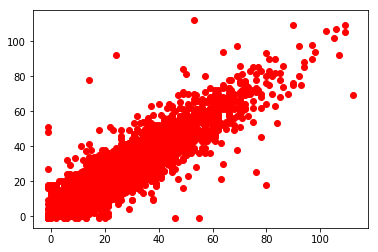

In [145]:
x = []
y = []
for idx in range(0, len(PM2_5)-window-1):
    # window_vals = PM2_5[idx: idx + window]
    window_val = PM2_5[idx + window - 1]
    # print(window_vals)
    # x.append(sum(window_vals) / len(window_vals))
    x.append(window_val)
    y.append(PM2_5[idx+window])
    
plt.plot(x, y, 'ro')

##### RAINFALL

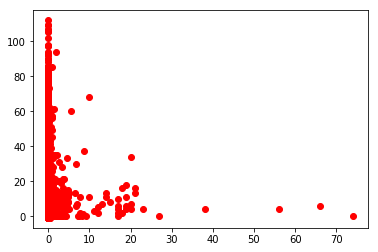

In [156]:
length = len(PM2_5)
howfar = 1
plt.plot(RAINFALL[0:length-howfar], PM2_5[howfar:length], 'ro')

#### PM10

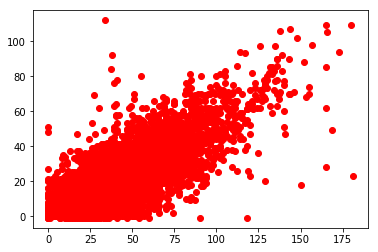

In [159]:
length = len(PM2_5)
howfar = 1
plt.plot(PM10[0:length-howfar], PM2_5[howfar:length], 'ro')

#### AMB_TEMP 

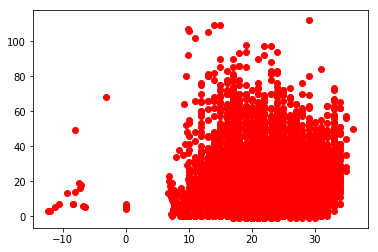

In [169]:
length = len(PM2_5)
howfar = 1
plt.plot(AMB_TEMP[0:length-howfar], PM2_5[howfar:length], 'ro')

#### WIND_SPEED

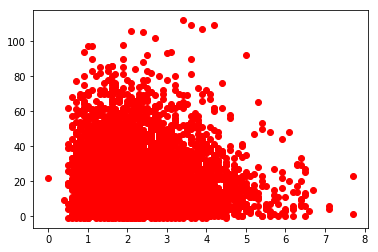

In [170]:
length = len(PM2_5)
howfar = 1
plt.plot(WIND_SPEED[0:length-howfar], PM2_5[howfar:length], 'ro')

#### WIND_DIREC

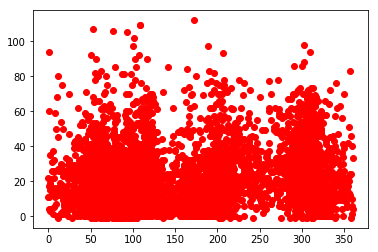

In [172]:
length = len(PM2_5)
howfar = 1
plt.plot(WIND_DIREC[0:length-howfar], PM2_5[howfar:length], 'ro')

#### WS_HR

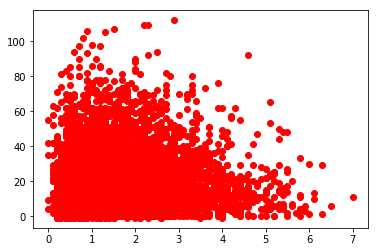

In [173]:
length = len(PM2_5)
howfar = 1
plt.plot(WS_HR[0:length-howfar], PM2_5[howfar:length], 'ro')